In [2]:
import pandas as pd
import numpy as np

import os
import re

# get the list of files and directories in the raw data  directory
directory = 'Data/Nb_Strip/'
text_files = os.listdir(directory)

data_list = []


# add the data to each sample
for file in text_files:
    data = pd.read_csv(directory+file,delimiter='\t').drop('Unnamed: 6', axis=1)
    data = data[data['freq/Hz']!=0.0]
    data = data.astype({'cycle number': int})
    
    data_list.append(data)

In [3]:
from scipy.special import hermite
import matplotlib.pyplot as plt

def Gaussian_Func(x,sigma):
    y = np.exp(-x**2/(2*sigma**2)) / (2.5066282*sigma)
    return y

def Gaussian_Derivative(x,n,sigma):
    hermite_poly = hermite(n)
    y = (-1)**n * Gaussian_Func(x,sigma) * hermite_poly(x/(1.41421356*sigma))
    return y

def quad(f, a, b, n=5):
    # Generate the quadrature rule coefficients
    x, w = np.polynomial.legendre.leggauss(n)
    
    # Scale the quadrature points and weights to the interval [a, b]
    x_scaled = 0.5 * (b - a) * x + 0.5 * (b + a)
    w_scaled = 0.5 * (b - a) * w
    
    # Evaluate the function at the quadrature points and sum up the weighted contributions
    integral = np.sum(w_scaled[:,None] * f(x_scaled),axis=0)
    
    return integral

def re_integrand(x, fn, fm, gaussian_sigma):
    x_diff = x[:,None] - fn[None,:] + fm[None,:]
    return Gaussian_Func(x, gaussian_sigma)[:,None] / (1 + np.exp(-2 * x_diff))

def im_integrand(x, fn, fm, gaussian_sigma):
    x_diff = x[:,None] - fn[None,:] + fm[None,:]
    return Gaussian_Func(x, gaussian_sigma)[:,None] * np.exp(-x_diff) / (1 + np.exp(-2 * x_diff))

def norm_integrand(x, fn, fm, k, gaussian_sigma):
    x_diff = x[:,None] - fn[None,:] + fm[None,:]
    return Gaussian_Derivative(x_diff,k,gaussian_sigma)*Gaussian_Derivative(x,k,gaussian_sigma)[:,None]

def integrate_test_functions(log_fm,log_fn,gaussian_sigma):

    #Integrate the test functions
    fn_mesh, fm_mesh = np.meshgrid(log_fm, log_fn, indexing='ij')
    
    # reshape fn_mesh and fm_mesh into column vectors
    fn = fn_mesh.flatten()
    fm = fm_mesh.flatten()
    
    #Real integral
    # integral = np.array([quad(lambda y: Gaussian_Func(y,gaussian_sigma)*1/(1+np.exp(-2*(y-fn+fm))), -3*gaussian_sigma, 3*gaussian_sigma) for fn, fm in zip(fn_mesh.flatten(), fm_mesh.flatten())])
    integral = quad(lambda y: re_integrand(y,fn,fm,gaussian_sigma), -3*gaussian_sigma, 3*gaussian_sigma)
                                   
    A_re = integral.reshape(fn_mesh.shape)
    
    #Imag integral
    # integral = np.array([quad(lambda y: Gaussian_Func(y,gaussian_sigma)*np.exp(-(y-fn+fm))/(1+np.exp(-2*(y-fn+fm))), -3*gaussian_sigma, 3*gaussian_sigma) for fn, fm in zip(fn_mesh.flatten(), fm_mesh.flatten())])    
    integral = quad(lambda y: im_integrand(y,fn,fm,gaussian_sigma), -3*gaussian_sigma, 3*gaussian_sigma)
    
    A_im = integral.reshape(fn_mesh.shape)
    
    return A_re, A_im

def Fit_Function_2(params, A_re, A_im, f_m, derivative = 0):
    x = params[0:-3]
    C = params[-3]

    R = params[-2]
    L = params[-1]


    if derivative == 1:

        jac_re = np.zeros((f_m.shape[0],params.shape[0]))
        jac_im = np.zeros((f_m.shape[0],params.shape[0]))

        jac_re[:,0:-3] = A_re
        jac_im[:,0:-3] = A_im
        jac_re[:,-2] = np.ones((f_m.shape[0]))
        jac_im[:,-3] = -np.exp(-f_m)
        jac_im[:,-1] = np.exp(f_m)

        return jac_re, jac_im

    else:
        Z_sim_re = np.matmul(A_re,x)+R
        Z_sim_im = np.matmul(A_im,x)+np.exp(f_m)*L-np.exp(-f_m)*C
        return Z_sim_re, Z_sim_im

def Fit_Function_1(params, A_re, A_im, f_m, derivative = 0):
    x = params[0:-4]
    w = np.exp(f_m)
    w_o = np.exp(params[-3])
    R2 = params[-4]

    R1 = params[-2]
    L = params[-1]


    if derivative == 1:

        jac_re = np.zeros((f_m.shape[0],params.shape[0]))
        jac_im = np.zeros((f_m.shape[0],params.shape[0]))

        dR2_re = 1/(1+(w/w_o)**2)
        dR2_im = (-w/w_o)/(1+(w/w_o)**2)

        dw_o_re = (-1/w_o**2)*(-2*R2*w/w_o)/(1+(w/w_o)**2)**2
        dw_o_im = (-1/w_o**2)*((2*w**2/w_o)/(1+(w/w_o)**2)**2-w/(1+(w/w_o)**2))

        jac_re[:,0:-4] = A_re
        jac_im[:,0:-4] = A_im
        jac_re[:,-2] = np.ones((f_m.shape[0]))
        jac_re[:,-3] = dw_o_re
        jac_im[:,-3] = dw_o_im
        jac_re[:,-4] = dR2_re
        jac_im[:,-4] = dR2_im
        jac_im[:,-1] = np.exp(f_m)

        return jac_re, jac_im

    else:

        Z_RC_re = R2/(1+(w/w_o)**2)
        Z_RC_im = (-R2*w/w_o)/(1+(w/w_o)**2)

        Z_sim_re = np.matmul(A_re,x)+R1+Z_RC_re
        Z_sim_im = np.matmul(A_im,x)+np.exp(f_m)*L+Z_RC_im

        return Z_sim_re, Z_sim_im
    

def generalized_DRT(params, A_re, A_im, f_m, derivative = 0):
    x_re = params[0:A_re.shape[1]]
    x_im = params[A_re.shape[1]:A_re.shape[1]+A_im.shape[1]]

    R1 = params[-2]
    L = params[-1]


    if derivative == 1:

        jac_re = np.zeros((f_m.shape[0],params.shape[0]))
        jac_im = np.zeros((f_m.shape[0],params.shape[0]))


        jac_re[:A_re.shape[0],:A_re.shape[1]] = A_re
        jac_im[:A_im.shape[0],A_re.shape[1]:A_re.shape[1]+A_im.shape[1]] = A_im
        jac_re[:,-2] = np.ones((f_m.shape[0]))
        jac_im[:,-1] = np.exp(f_m)

        return jac_re, jac_im

    else:

        Z_sim_re = np.matmul(A_re,x_re)+R1
        Z_sim_im = np.matmul(A_im,x_im)+np.exp(f_m)*L

        return Z_sim_re, Z_sim_im    

from scipy.optimize import lsq_linear, minimize

def cost_func(params,f_m,A_re,A_im,b,norm_matrix,fit_function):

    #DRT_params = A_re.shape[1]
    
    x = params
    
    Z_sim_re, Z_sim_im = fit_function(params,A_re,A_im,f_m)


    Z_exp_re = np.real(b)
    Z_exp_im = np.imag(b)


    
    Re_cost = np.linalg.norm((Z_exp_re-Z_sim_re))
    Im_cost = np.linalg.norm((Z_exp_im-Z_sim_im))
    Re_norm_cost = (np.matmul(x,np.matmul(norm_matrix,x.T)))
    Im_norm_cost = (np.matmul(x,np.matmul(norm_matrix,x.T)))
    
    cost = Re_cost + Im_cost + Re_norm_cost + Im_norm_cost

    return cost

def cost_func_jac(params,f_m,A_re,A_im,b,norm_matrix,fit_function):
        
    #DRT_params = A_re.shape[1]

    Z_sim_re, Z_sim_im = fit_function(params,A_re,A_im,f_m)

    dZ_sim_re, dZ_sim_im = fit_function(params,A_re,A_im,f_m,derivative=1)

    Z_exp_re = np.real(b)
    Z_exp_im = np.imag(b)

    dRe_cost = -2*np.sum((Z_exp_re-Z_sim_re)[:,None]*dZ_sim_re,axis=0)
    dIm_cost = -2*np.sum((Z_exp_im-Z_sim_im)[:,None]*dZ_sim_im,axis=0)
    
    x = params
    
    dRe_norm_cost = np.matmul(x,norm_matrix)+np.matmul(norm_matrix,x.T)
    dIm_norm_cost = np.matmul(x,norm_matrix)+np.matmul(norm_matrix,x.T)

    dcost = dRe_cost + dRe_norm_cost + dIm_cost + dIm_norm_cost

    return dcost

def DRT_Fit(measured_frequencies, measured_Z, fitting_frequencies, reg_params, R0, L0, C0):
    
    f_m = measured_frequencies
    f_n = fitting_frequencies
    Z_m = measured_Z
       
    reg_order = reg_params.shape[0]
    gaussian_width = (np.max(fitting_frequencies)-np.min(fitting_frequencies))/fitting_frequencies.shape[0]
        
    #Generate parameter array
    #real, imag, resistance, inductance
    x_params = np.random.rand((2*fitting_frequencies.shape[0]+2))*1e-3
    #x_params[-4] = 0.0
    #x_params[-3] = 0.0
    x_params[-2] = R0
    x_params[-1] = L0
    
    #Integrate the test functions wrt the measured frequencies
    A_re, A_im = integrate_test_functions(measured_frequencies, fitting_frequencies, gaussian_width/2.355)
    
    #Calculate the regularization matrix
    fn_mesh, fm_mesh = np.meshgrid(f_n, f_n, indexing='ij')
    
    fn = fn_mesh.flatten()
    fm = fm_mesh.flatten()
    
    M = np.zeros((x_params.shape[0],x_params.shape[0]))
    for k in range(reg_order):
        integral = quad(lambda y: norm_integrand(y,fn,fm,k,gaussian_width/2.355), -3*gaussian_width/2.355, 3*gaussian_width/2.355)
        M[:fitting_frequencies.shape[0],:fitting_frequencies.shape[0]] += reg_params[k]*integral.reshape(fn_mesh.shape).T
        M[fitting_frequencies.shape[0]:2*fitting_frequencies.shape[0],fitting_frequencies.shape[0]:2*fitting_frequencies.shape[0]] += reg_params[k]*integral.reshape(fn_mesh.shape).T
    
    
    #Fit to experimental data
    b = Z_m
    
    #Solve for parameters
    res = minimize(cost_func,x_params,args=(f_m,A_re,A_im,b,M,generalized_DRT),method='BFGS')
    x_params = res['x']
    
    #Calculate the gamma function coefficients
    #x = x_params[:-2]
    x_re = x_params[0:A_re.shape[1]]
    x_im = x_params[A_re.shape[1]:A_re.shape[1]+A_im.shape[1]]
    #x_im = x_re
    #w_o = x_params[-3]
    R = x_params[-2]
    #R2 = x_params[-4]
    L = x_params[-1]
    
    return {'x_re': x_re,
            'x_im': x_im, 
            'R': R,
            'L': L,
            'A_re': A_re,
            'A_im': A_im,
            'f_m': f_m,
            'params': x_params}






def Bode_Plot(data,title=None):

    
    fig, ax = plt.subplots(2,1,figsize = (4,5),dpi=200)

    ax[0].set_title(title)
    
    for key in data.keys():
        cycle_data = data[key]

    
        freq = cycle_data['Freq']
        ReZ = cycle_data['ReZ']
        ImZ = cycle_data['Imz']
        ax[0].plot(freq,ReZ,lw=0.5)
        ax[1].plot(freq,ImZ,lw=0.5)

        
    if Z_exp is not None:
        freq = Z_exp[0]
        ReZ = np.real(Z_exp[1])
        ImZ = np.imag(Z_exp[1])
        ax[0].scatter(freq,ReZ,s=5,marker='x',lw=0.5)
        ax[1].scatter(freq,ImZ,s=5,marker='x',lw=0.5)

    ax[0].set_xscale('log')
    # ax[0].set_xlabel('Frequency [rad/s]')
    ax[0].set_ylabel('Real Impedence [Ohm]')
        
    ax[1].set_xscale('log')
    ax[1].set_xlabel('Frequency [rad/s]')
    ax[1].set_ylabel('Imaginary Impedence [Ohm]')
    
    plt.tight_layout()

In [4]:
"""Model Fitting"""






import time

output = {}

#Generate regularization hyper-parameter array
reg_params = np.array((5e-2,5e-2,5e-3))

for row, data in enumerate(data_list[0:1]):    

    for cycle in range(data['cycle number'].max()):
    #for cycle in range(10):


        cycle_data = data[data['cycle number'] == cycle+1]

        #Load data
        Freq = np.array(cycle_data['freq/Hz'])
        ReZ = np.array(cycle_data['Re(Z)/Ohm'])
        ImZ = -np.array(cycle_data['-Im(Z)/Ohm'])
        Z = ReZ + 1j*ImZ


        """Pre-processing"""

        ind = Freq > 1e5

        Z_sim = lambda w, R, L: R + 1j*w*L

        cost = lambda x_params, w, Z, Z_sim: np.linalg.norm((Z-Z_sim(w,x_params[0],x_params[1])))

        x_params = np.zeros((2))

        res = minimize(cost,x_params,args=(Freq[ind],Z[ind],Z_sim),method='BFGS')
        x_params = res['x']

        R = x_params[0]
        L = x_params[1]

        Z -= Z_sim(np.array(cycle_data['freq/Hz']),x_params[0],x_params[1])


        """DRT Parameters"""

        #PARAMS
        f_min = np.min(Freq)/1000
        f_max = np.max(Freq)/10
        fitting_params_per_decade = 4


        #Convert to log frequency
        log_f_min = np.log(f_min)
        log_f_max = np.log(f_max)

        #Generate the fitting test function offsets
        number_of_fitting_params = int(fitting_params_per_decade*(log_f_max-log_f_min))
        log_f_n = np.linspace(log_f_min,log_f_max,number_of_fitting_params)
        gaussian_width = (np.max(log_f_n)-np.min(log_f_n))/log_f_n.shape[0]

        #Convert experimental frequencies to log space
        log_Freq = np.log(Freq)
  
        

        
        # start the timer
        start_time = time.time()
        
        output[f'Data {row} Cycle {cycle}'] = DRT_Fit(log_Freq, Z, log_f_n, reg_params,2.0,0.0,0.0)
        output[f'Data {row} Cycle {cycle}']['E'] = np.array(cycle_data['<Ewe>/V'])
        output[f'Data {row} Cycle {cycle}']['I'] = np.array(cycle_data['<I>/mA'])
        output[f'Data {row} Cycle {cycle}']['ReZ'] = ReZ
        output[f'Data {row} Cycle {cycle}']['ImZ'] = ImZ
        output[f'Data {row} Cycle {cycle}']['Freq'] = Freq
        output[f'Data {row} Cycle {cycle}']['R'] = R
        output[f'Data {row} Cycle {cycle}']['L'] = L
        

        # end the timer
        end_time = time.time()
        
        # calculate the elapsed time
        elapsed_time = end_time - start_time
        
        # print the elapsed time
        print("Elapsed time: {:.2f} seconds".format(elapsed_time))



import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.transforms import Bbox

"""Plotting"""

x_re = []
x_im = []
Electrode_Potential = []
Current = []
Current_min = []
Current_max = []

#fig, (ax) = plt.subplots()
#ax.set_xlim(0.6,1.2)
#ax.set_ylim(-0.2,0.3)

for key in output.keys():



    cycle_output = output[key]

#    ax.scatter(cycle_output['ReZ'],cycle_output['ImZ'])
#    ax.plot(np.matmul(cycle_output['A_re'],cycle_output['x'])+cycle_output['R'],np.matmul(cycle_output['A_im'],cycle_output['x'])+np.exp(cycle_output['f_m'])*cycle_output['L']-np.exp(-cycle_output['f_m'])*cycle_output['C'])


    x_re.append(cycle_output['x_re'])
    x_im.append(cycle_output['x_im'])
    Electrode_Potential.append(cycle_output['E'][-1])
    Current.append(np.mean(cycle_output['I']))
    Current_max.append(np.max(cycle_output['I']))
    Current_min.append(np.min(cycle_output['I']))

x_re = np.array(x_re).T
x_im = np.array(x_im).T
Electrode_Potential = np.array(Electrode_Potential)
Current = np.array(Current)
Current_max = np.array(Current_max)
Current_min = np.array(Current_min)


Elapsed time: 2.36 seconds
Elapsed time: 2.21 seconds
Elapsed time: 2.36 seconds
Elapsed time: 2.19 seconds
Elapsed time: 2.16 seconds
Elapsed time: 2.19 seconds
Elapsed time: 1.91 seconds
Elapsed time: 2.11 seconds
Elapsed time: 1.97 seconds
Elapsed time: 2.27 seconds
Elapsed time: 2.10 seconds
Elapsed time: 2.02 seconds
Elapsed time: 2.34 seconds
Elapsed time: 2.15 seconds
Elapsed time: 2.22 seconds
Elapsed time: 2.22 seconds
Elapsed time: 2.20 seconds
Elapsed time: 2.02 seconds
Elapsed time: 2.10 seconds
Elapsed time: 2.22 seconds
Elapsed time: 1.88 seconds
Elapsed time: 2.15 seconds
Elapsed time: 2.10 seconds
Elapsed time: 1.83 seconds
Elapsed time: 2.03 seconds
Elapsed time: 2.90 seconds
Elapsed time: 1.65 seconds
Elapsed time: 1.95 seconds
Elapsed time: 2.15 seconds
Elapsed time: 1.98 seconds
Elapsed time: 1.95 seconds
Elapsed time: 2.08 seconds
Elapsed time: 1.87 seconds
Elapsed time: 1.92 seconds
Elapsed time: 2.19 seconds
Elapsed time: 2.05 seconds
Elapsed time: 1.80 seconds
E

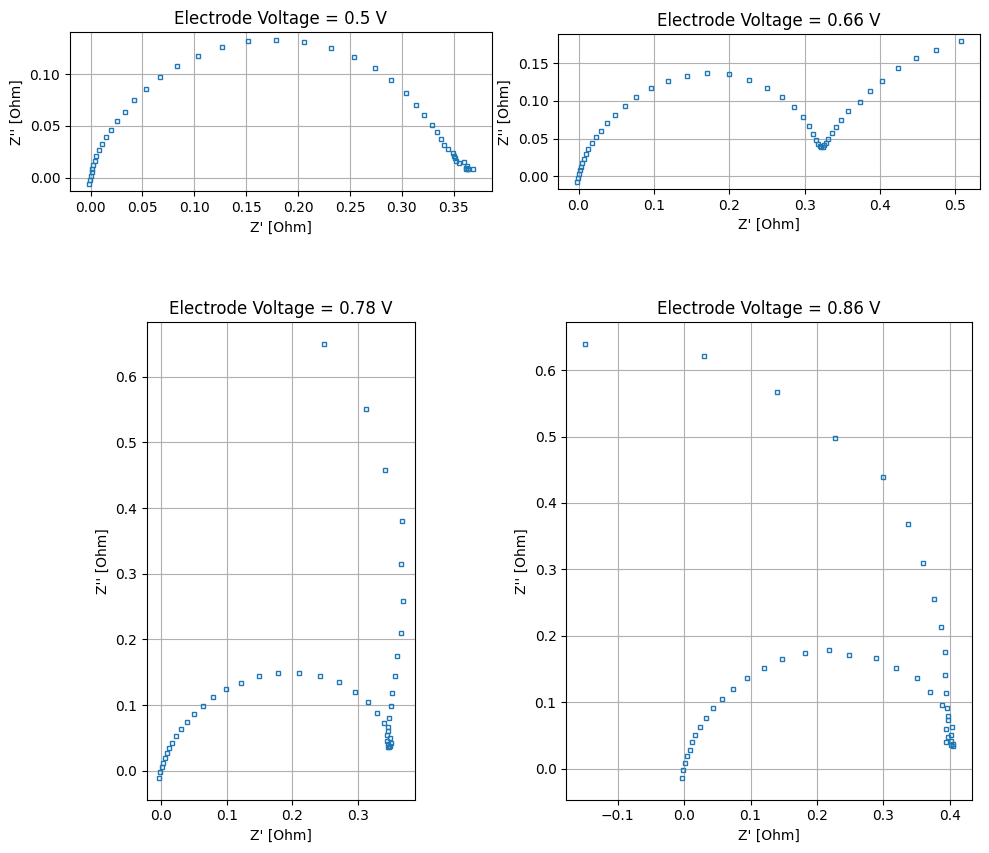

<Figure size 640x480 with 0 Axes>

In [5]:
fig, axs = plt.subplots(2,2,figsize=(10,10))

#ax.set_xlim(0.6,1.2)
#ax.set_ylim(-0.2,0.3)

for i, key in enumerate([list(output.keys())[key] for key in [0,20,35,45]]):
    cycle_output = output[key]

    
    Z_exp_re = cycle_output['ReZ'] - cycle_output['R']
    Z_exp_im = cycle_output['ImZ'] - np.exp(cycle_output['f_m'])*cycle_output['L']
    #Z_sim_re = np.matmul(cycle_output['A_re'],cycle_output['x'])+cycle_output['R']
    #Z_sim_im = np.matmul(cycle_output['A_im'],cycle_output['x'])+np.exp(cycle_output['f_m'])*cycle_output['L']-np.exp(-cycle_output['f_m'])*cycle_output['C']

    #Z_sim_re, Z_sim_im = generalized_DRT(cycle_output['params'], cycle_output['A_re'], cycle_output['A_im'], cycle_output['f_m'])

    electrode_voltage = cycle_output['E'][0].round(2)

    ax = axs.flatten()[i]

    ax.set_title(f"Electrode Voltage = {electrode_voltage} V")
    ax.plot(Z_exp_re,-Z_exp_im,marker='s',markersize=2.5,fillstyle='none',linestyle='none')
    ax.set_aspect('equal')

    ax.set_xlabel("Z' [Ohm]")
    ax.set_ylabel("Z'' [Ohm]")

    ax.grid('both')


fig.tight_layout()
plt.show()
plt.savefig("figures/nyquist.png")

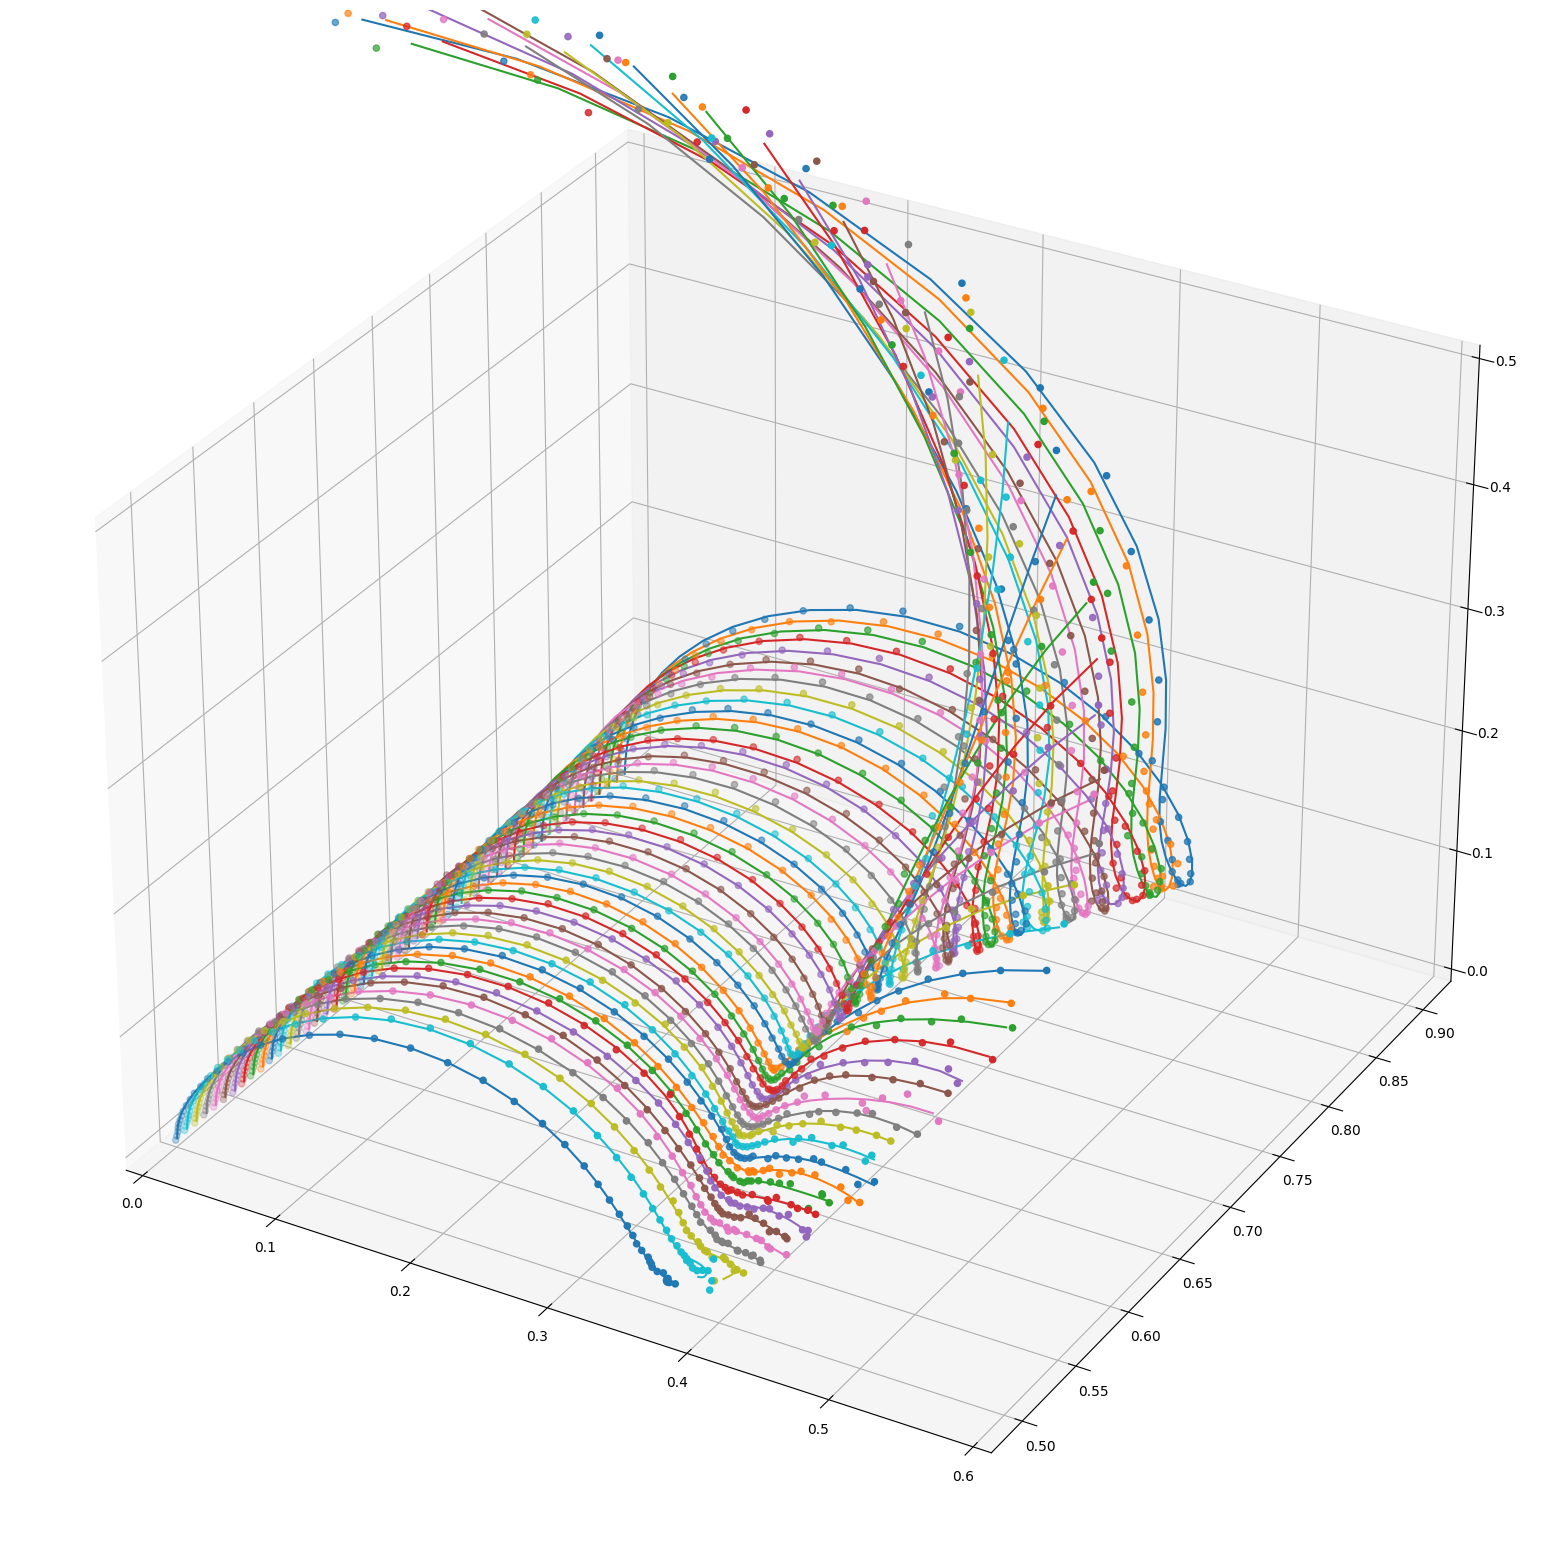

In [6]:
ax = plt.figure(figsize=(20,20)).add_subplot(projection='3d')

ax.set_xlim(0,.6)
ax.set_zlim(0,0.5)

for i, key in reversed(list(enumerate(output.keys()))):
    cycle_output = output[key]

    
    Z_exp_re = cycle_output['ReZ'] - cycle_output['R']
    Z_exp_im = cycle_output['ImZ'] - np.exp(cycle_output['f_m'])*cycle_output['L']
    #Z_sim_re = np.matmul(cycle_output['A_re'],cycle_output['x'])+cycle_output['R']
    #Z_sim_im = np.matmul(cycle_output['A_im'],cycle_output['x'])+np.exp(cycle_output['f_m'])*cycle_output['L']-np.exp(-cycle_output['f_m'])*cycle_output['C']

    Z_sim_re, Z_sim_im = generalized_DRT(cycle_output['params'], cycle_output['A_re'], cycle_output['A_im'], cycle_output['f_m'])

    ax.scatter(Z_exp_re,Electrode_Potential[i].repeat(Z_exp_re.shape[0]),-Z_exp_im)
    ax.plot(Z_sim_re,Electrode_Potential[i].repeat(Z_sim_re.shape[0]),-Z_sim_im)



plt.show()





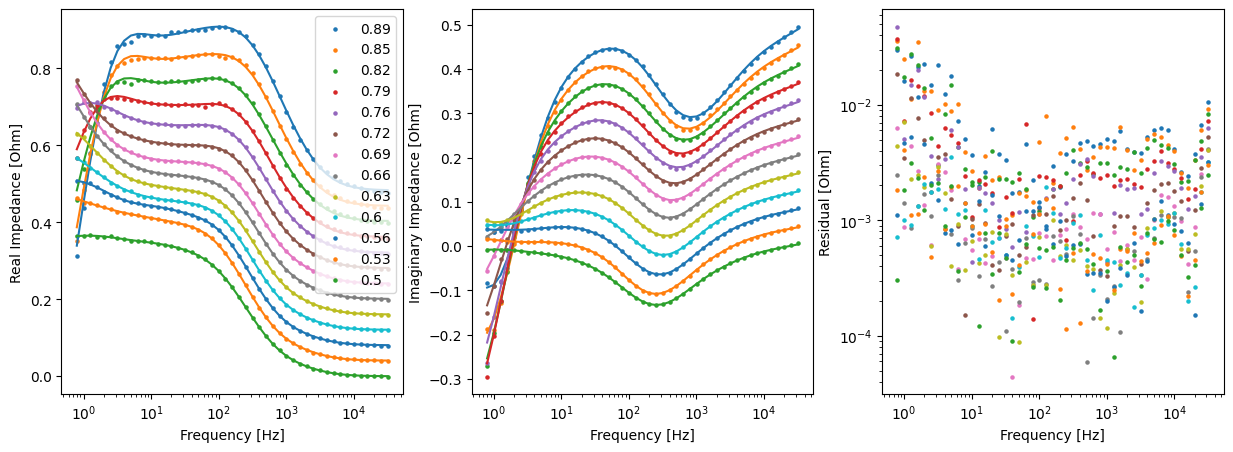

In [7]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

axs[0].set_xscale('log')
axs[0].set_xlabel('Frequency [Hz]')
axs[0].set_ylabel('Real Impedance [Ohm]')

axs[1].set_xscale('log')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Imaginary Impedance [Ohm]')

axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('Frequency [Hz]')
axs[2].set_ylabel('Residual [Ohm]')

for i, key in reversed(list(enumerate(output.keys()))[::4]):
    cycle_output = output[key]

    Freq = cycle_output['Freq']/(2*np.pi)
    
    Z_exp_re = cycle_output['ReZ'] - cycle_output['R']
    Z_exp_im = cycle_output['ImZ'] - np.exp(cycle_output['f_m'])*cycle_output['L']
    # Z_sim_re = np.matmul(cycle_output['A_re'],cycle_output['x'])
    # Z_sim_im = np.matmul(cycle_output['A_im'],cycle_output['x'])-np.exp(-cycle_output['f_m'])*cycle_output['C']

    Z_sim_re, Z_sim_im = generalized_DRT(cycle_output['params'], cycle_output['A_re'], cycle_output['A_im'], cycle_output['f_m'])

    res = np.sqrt((Z_exp_re-Z_sim_re)**2 + (Z_exp_im-Z_sim_im)**2)

    offset = 0.01*i

    axs[0].scatter(Freq, Z_exp_re+offset, label = round(Electrode_Potential[i],2),s=5)
    axs[0].plot(Freq, Z_sim_re+offset)
    axs[1].scatter(Freq, Z_exp_im+offset,s=5)
    axs[1].plot(Freq, Z_sim_im+offset)

    axs[2].scatter(Freq,res, s=5)

axs[0].legend()

plt.savefig('figures/bodeplot.png')

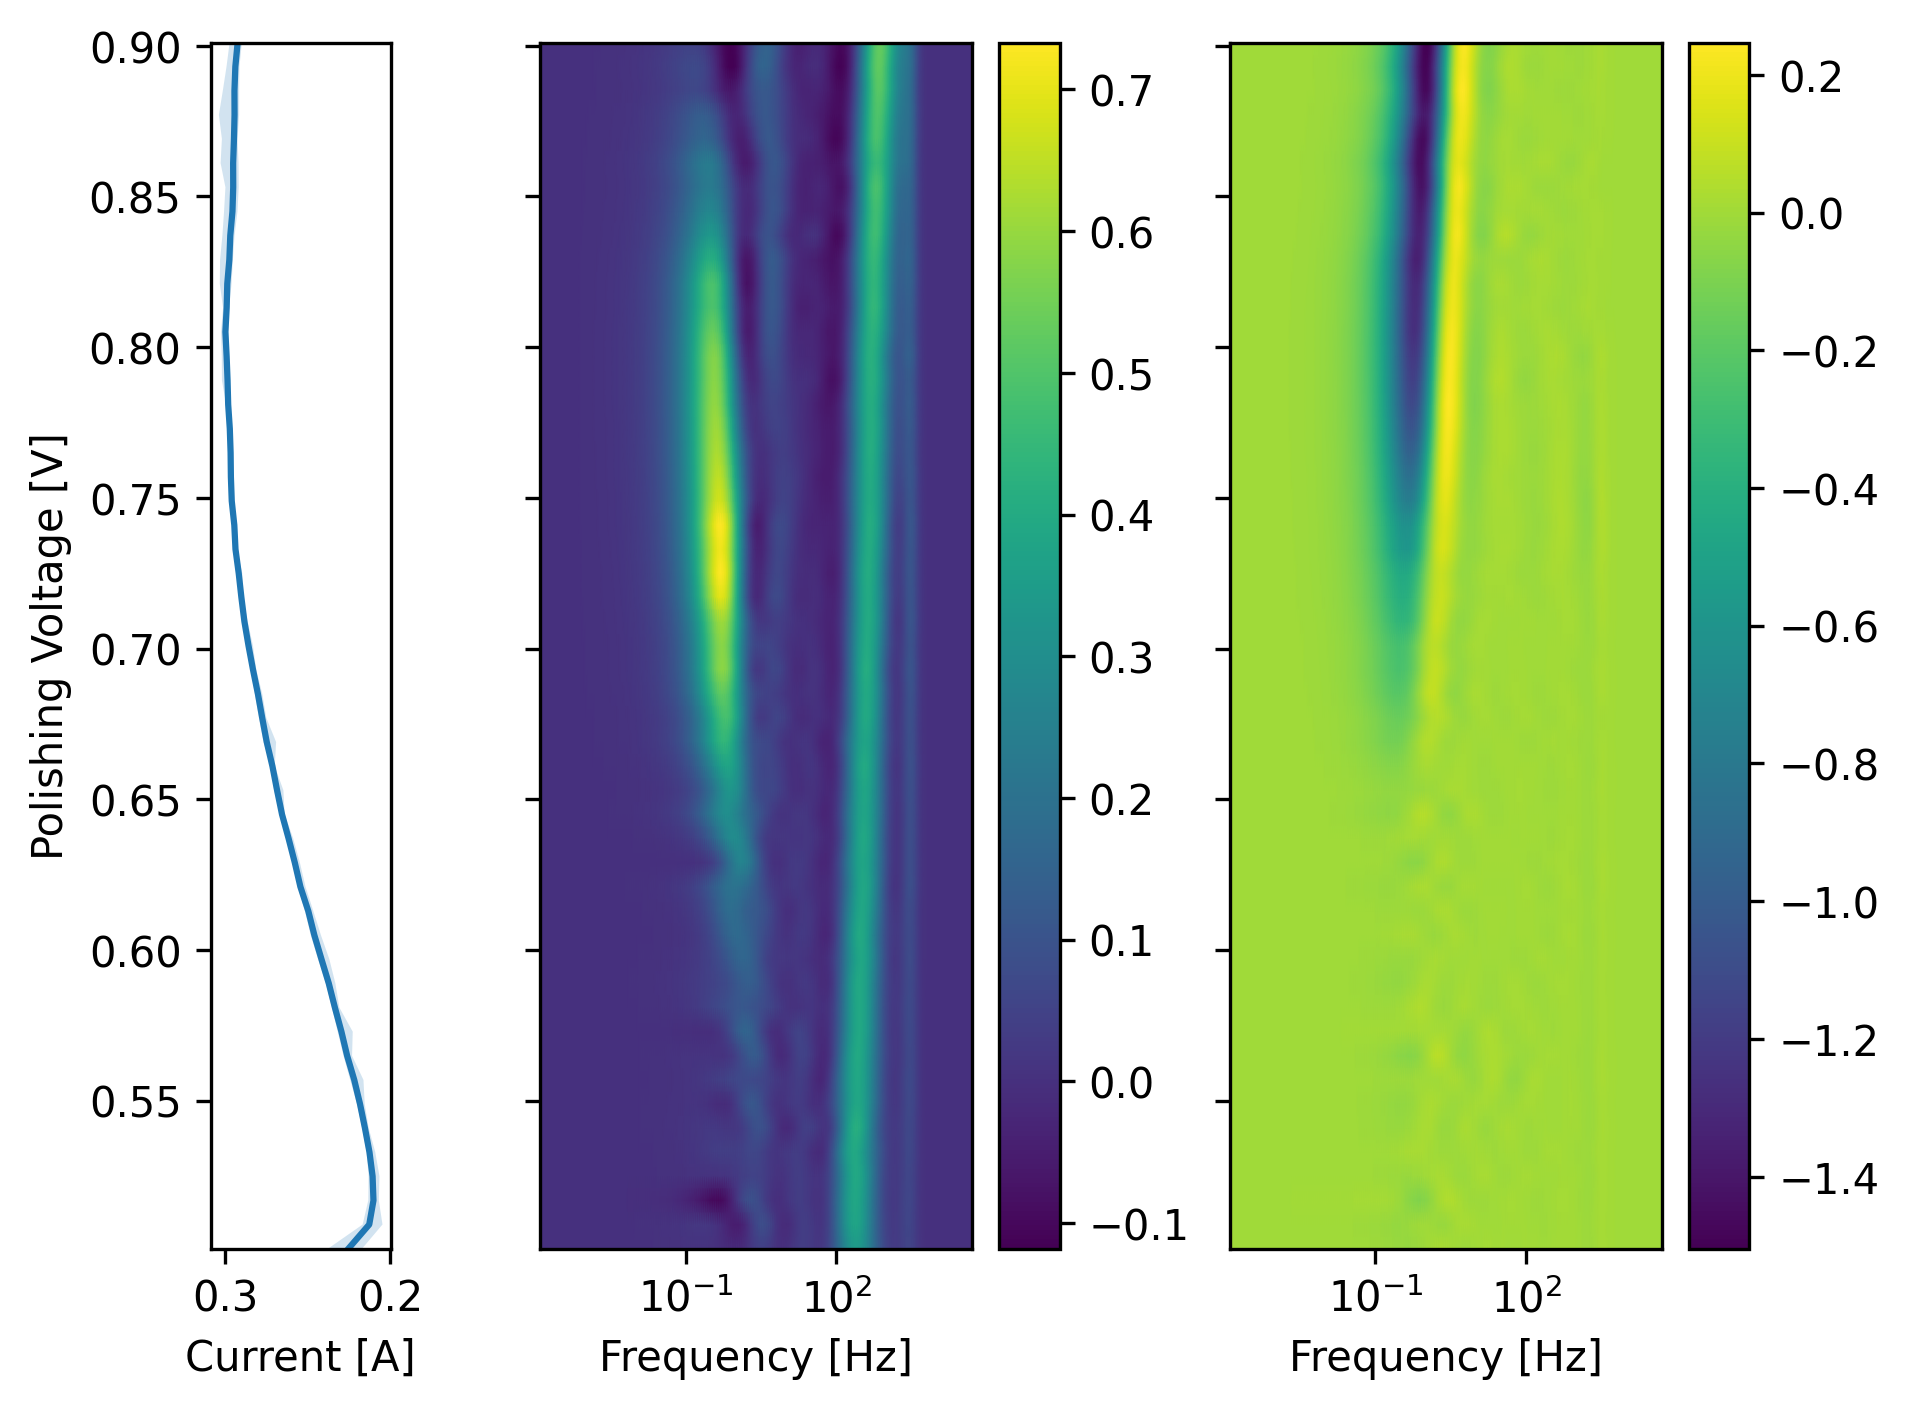

In [8]:

"""Plotting"""

# Plot gamma functions
#Params
plot_freq_min = np.min(Freq)/1000
plot_freq_max = np.max(Freq)*10
plot_points_per_decade = 12


#Convert to log
log_plot_freq_min = np.log(plot_freq_min)
log_plot_freq_max = np.log(plot_freq_max)
plot_points = int(plot_points_per_decade*(log_plot_freq_max-log_plot_freq_min))

#Generate plotting frequencies
log_plot_freq = np.linspace(log_plot_freq_min,log_plot_freq_max,plot_points)

plot_freq = np.exp(log_plot_freq)


gamma1 = np.sum((x_re[None,:,:]-x_im[None,:,:])*Gaussian_Func(log_plot_freq[:,None,None]-log_f_n[None,:,None],gaussian_width),axis=1)

gamma2 = np.sum((x_re[None,:,:]+x_im[None,:,:])*Gaussian_Func(log_plot_freq[:,None,None]-log_f_n[None,:,None],gaussian_width),axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,dpi=300,sharey=True,gridspec_kw={'width_ratios': [1, 3, 3]})

X,Y = np.meshgrid(plot_freq/(2*np.pi),Electrode_Potential,indexing='ij')

mesh1 = ax2.pcolormesh(X,Y,gamma1,shading='gouraud', cmap='viridis')
cbar = fig.colorbar(mesh1)

#for i in range(gamma.shape[1]):
#    ax2.plot(plot_freq,gamma[:,i])

mesh2 = ax3.pcolormesh(X,Y,gamma2,shading='gouraud', cmap='viridis')
cbar = fig.colorbar(mesh2)
ax2.set_xscale('log')
ax2.set_xlabel('Frequency [Hz]')
#ax2.set_xticks([1e1,1e3,1e5])
ax3.set_xscale('log')
ax3.set_xlabel('Frequency [Hz]')

ax1.plot(Current/1000,Electrode_Potential)
ax1.fill_betweenx(Electrode_Potential, Current_min/1000, Current_max/1000, alpha = 0.2)
ax1.set_ylabel('Polishing Voltage [V]')
ax1.set_xlabel('Current [A]')
ax1.invert_xaxis()
# ax1.set_xticks([0.1,0.2])
#ax1.set_yticks(np.arange(0.5,1.0,0.1))
# ax1.set_xlim(0.2,0)

fig.subplots_adjust(wspace = 0)
fig.tight_layout()

plt.savefig('figures/gamma.png')


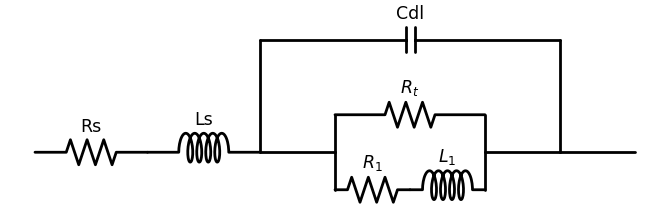

In [43]:
import schemdraw
import schemdraw.elements as elm



with schemdraw.Drawing() as d:
    Rs = d.add(elm.Resistor().label('Rs').length(d.unit*0.75))
    Ls = d.add(elm.Inductor2().label('Ls').length(d.unit*0.75))
    d.push()
    d += elm.Line().length(d.unit*0.75).up()
    Cdl = d.add(elm.Capacitor().label('Cdl').length(d.unit*2).right())
    d += elm.Line().length(d.unit*0.75).down()
    d.pop()
    d += elm.Line().length(d.unit*0.5).right()
    d.push()
    d += elm.Line().length(d.unit*0.25).up()
    Rt = d.add(elm.Resistor().label('$R_t$').right())
    d += elm.Line().length(d.unit*0.25).down()
    d.pop()
    d += elm.Line().length(d.unit*0.25).down()
    R1 = d.add(elm.Resistor().label('$R_1$').length(d.unit*0.5).right())
    L1 = d.add(elm.Inductor2().label('$L_1$').length(d.unit*0.5).right())
    d += elm.Line().length(d.unit*0.25).up()
    d += elm.Line().length(d.unit*0.5).right()
    d.push()
    d += elm.Line().length(d.unit*0.5).right()


    d.save('figures/ec.png')

[ 3.25768051e-01  6.89356266e-01 -1.12363937e+02  1.36725636e+03
  1.74600040e-03]
[ 3.39259694e-01  6.80930948e-01 -2.43979382e+02  4.86456752e+03
  1.21082299e-03]
[ 1.39952858e+00  8.43112347e-01 -4.56538877e+01  9.81005010e+02
  2.29456519e-01]
[ 5.46223481e+03  8.73496428e-01 -2.26056894e+02  1.39604739e+03
  2.23053824e-01]


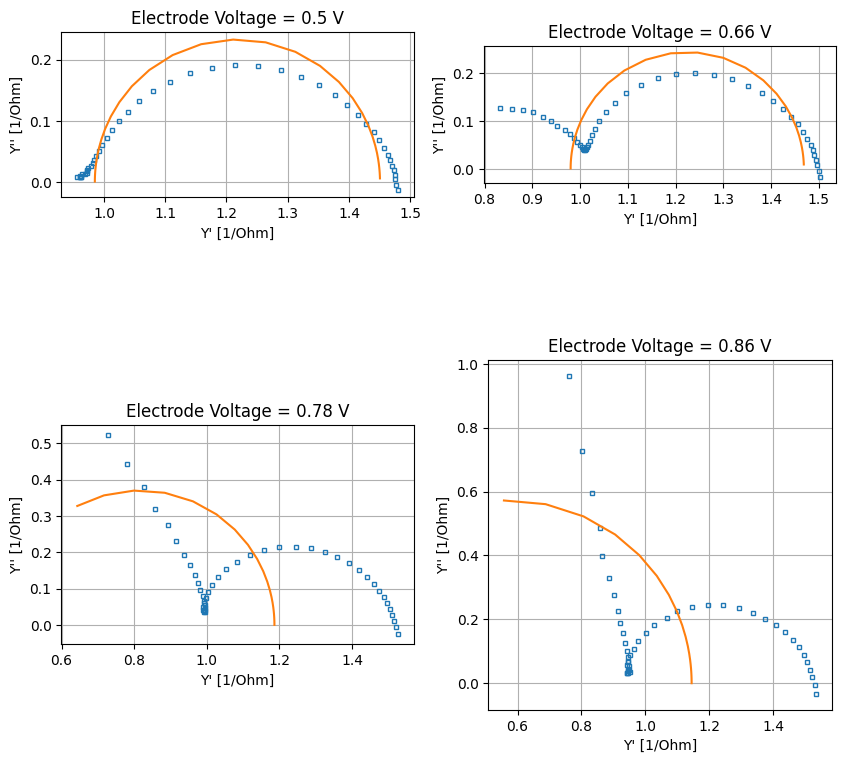

In [44]:
def RC_Circuit(w,Rt,Ri,Li):
    Y = 1/Rt + 1/(Ri+1j*w*Li)
    return Y

def RZ_Circuit(w,Z_f,C_dl):
    
    Y = Z_f+1j*w*C_dl
    return Y

fig, axs = plt.subplots(2,2,figsize=(10,10))

for i, key in enumerate([list(output.keys())[key] for key in [0,20,35,45]]):
    cycle_output = output[key]

    Freq = cycle_output['Freq']

    Z_exp_re = cycle_output['ReZ']
    Z_exp_im = cycle_output['ImZ'] - np.exp(cycle_output['f_m'])*cycle_output['L']
    Z = Z_exp_re + 1j*Z_exp_im
    Y = 1/Z

    Eq_Circuit = lambda w, q1, Rs, p1, p2, C_dl: 1/(Rs + 1/RZ_Circuit(w,RC_Circuit(w,q1,p1,p2),C_dl))

    cost = lambda x_params, w, Y, Y_sim: np.linalg.norm((Y-Y_sim(w,*x_params)))

    x_params = np.ones((5))

    

    res = minimize(cost,x_params,args=(Freq,Y,Eq_Circuit),method='BFGS')
    x_params = res['x']

    print(x_params)

    Y_sim = Eq_Circuit(Freq,*x_params)

    Z_sim = 1/Y_sim

    electrode_voltage = cycle_output['E'][0].round(2)

    ax = axs.flatten()[i]

    ax.set_title(f"Electrode Voltage = {electrode_voltage} V")
    ax.plot(Y.real,Y.imag,marker='s',markersize=2.5,fillstyle='none',linestyle='none')
    ax.plot(Y_sim.real,Y_sim.imag)
    ax.set_aspect('equal')

    ax.set_xlabel("Y' [1/Ohm]")
    ax.set_ylabel("Y'' [1/Ohm]")

    ax.grid('both')
